In [1]:
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
from os.path import join

import pymc3 as pm
from theano import tensor as tt, printing
import theano

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Warm-up: softmax in theano

In [3]:
# declare variables and softmax
v = tt.vector('v', dtype='float32')
tau = tt.scalar('tau')
softmax = 1 / (1 + tt.exp(tau * (v[1] - v[0])))

func = theano.function([tau, v], [softmax])

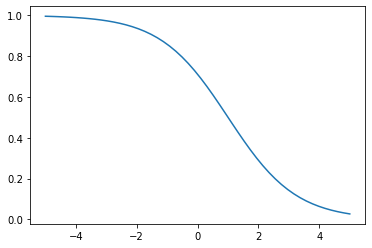

In [4]:
# run softmax for a couple of dummy 
res = []
va = 1.0
vb_values = np.linspace(-5, 5)
tau = 0.9

for v_ in [(va, x) for x in vb_values]:
    v = np.asarray(v_, dtype=np.float32)
    out = func(tau, v)
    res.append(out[0])
plt.plot(vb_values, res)
plt.show()

### Modeling

In [51]:
rl_mp = {}
df = pd.read_csv(join('_data', 'rl_mp.csv'))
choice = df.iloc[:, :100].values - 1
reward = df.iloc[:, 100:].values

nSubjects, nTrials = choice.shape

In [52]:
reward[:5, :5]

array([[-1,  1, -1, -1, -1],
       [ 1, -1, -1, -1, -1],
       [-1,  1, -1, -1,  1],
       [-1, -1, -1,  1, -1],
       [-1,  1, -1, -1, -1]], dtype=int64)

In [53]:
nIter = 1000
nChains = 4
nWarmup = 1000

In [54]:
choice[0] @ reward[0]

-10

In [59]:
choice_1 = choice[0]
reward_1 = reward[1]


In [118]:
r = tt.as_tensor_variable(np.zeros(11), 'r')
new_r = tt.set_subtensor(r[4:], 5)
theano.function([], new_r)()

array([0., 0., 0., 0., 5., 5., 5., 5., 5., 5., 5.])

In [119]:
test = tt.as_tensor_variable([0.1, 0.3], 'test')
test = tt.set_subtensor(test[:], [1, 2])
f = theano.function([], test)
f()

array([1., 2.])

In [105]:
a = np.random.multinomial(1, [0.4, 0.6])
print(a)
np.argmax(a)


[0 1]


1

In [133]:
from theano.tensor.nnet import softmax

v_ = np.array([0, 0])
# v = tt.as_tensor_variable(v_, 'v')
# pe = tt.as_tensor_variablnnet(np.zeros, 'pe')

def run(ch, rew, v_prev, alpha, tau):   
    p = tt.argmax(softmax(tau * v_prev))
#     ch = pm.Categorical.dist(p)
    
    pe = rew - v_prev[p]
    v_new = tt.set_subtensor(v_prev[:], v_prev[p] + alpha * pe)
    
    return v_new

ch = tt.as_tensor_variable(choice_1, 'ch')
rew = tt.as_tensor_variable(reward_1, 'rew')

with pm.Model() as model:
    alpha = pm.Uniform('alpha', 0, 1)
    tau = pm.Uniform('tau', 0, 10)

    res, _ = theano.scan(fn=run,
                        sequences=[ch, rew],
                        outputs_info=dict(initial=v_),
                        non_sequences=[alpha, tau])

0
0


In [ ]:
with model:
    trace = pm.sample(nIter, tune=nWarmup)

<ipython-input-137-2aa39882eb00>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(nIter, tune=nWarmup)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, alpha]


In [ ]:
with model:
    pm.plot_trace(trace)

In [24]:
def func(ch, rw, v_prev):
    print(ch)
    print(rw)
#     print(tt_a)
#     print(tt_t)
    v_f = ch.dot(rw) + v_prev
    v_f 
    print(v_f.ndim)
    return v_f #v_f
    
with pm.Model() as model:
    # pm3
#     alpha = pm.Uniform('alpha', 0, 1, shape=10)
#     tau = pm.Uniform('tau', 0, 10)
    
    # tt
    v0 = tt.as_tensor_variable(np.zeros(1, dtype=np.int64)[0], 'v0')
    tt_a = tt.as_tensor_variable(alpha, 'tt_a')
#     tt_t = tt.as_tensor_variable(tau, 'tt_t')
    
    tt_choice = tt.as_tensor_variable(choice, 'choice')
    tt_reward = tt.as_tensor_variable(reward, 'reward')
    x = tt.as_tensor_variable(nTrials, 'nTrials')

    results, updates = theano.scan(
                    fn=func,
                    sequences=[tt_choice, tt_reward],
                    outputs_info=dict(initial=v0),
                    non_sequences=None,
                    n_steps=x
                )
    fout = theano.function(inputs=[], outputs=[results], allow_input_downcast=True)
    print(fout())

choice[t]
reward[t]
0
[array([-10, -22, -31, -41, -44, -49, -55, -64, -72, -82], dtype=int64)]


In [68]:
def func(ch, rw, v_prev):
    v_f = ch.dot(rw) + v_prev
    return v_f
    
v0 = tt.as_tensor_variable(v0_, 'v0')

tt_choice = tt.as_tensor_variable(choice, 'choice')
tt_reward = tt.as_tensor_variable(reward, 'reward')
x = tt.as_tensor_variable(nTrials, 'nTrials')

results, updates = theano.scan(
                fn=func,
                outputs_info=dict(initial=v0),
                sequences=[tt_choice, tt_reward],
                n_steps=x
            )
fout = theano.function(inputs=[], outputs=[results])
fout()

[array([-10, -22, -31, -41, -44, -49, -55, -64, -72, -82], dtype=int64)]

In [7]:
preal = [0.1, 0.2, 0.6, 0.1]
y = np.random.choice(4, 1000, p=preal)
print(y)
with pm.Model():
    probs = []
    for k in range(4):
        _p = pm.Beta(name='p%i' % k, alpha=1, beta=1)
        probs.append(_p)

    p = tt.stack(probs)
    p1 = pm.Deterministic('p', p/p.sum())
    pm.Categorical(name='y', p=p1, observed=y)

    trace = pm.sample(draws=10000, tune=2000)

pm.traceplot(trace, varnames=['p'], lines=dict(p=preal))

[2 2 3 2 2 2 0 2 0 2 2 3 2 2 2 2 0 2 2 2 2 1 3 2 1 0 0 0 2 2 2 2 2 2 2 2 2
 2 2 1 2 1 2 2 3 2 2 1 2 2 1 3 2 1 2 2 1 1 3 2 3 2 2 1 2 2 2 2 2 2 2 1 1 1
 2 2 2 2 1 2 2 0 3 2 2 1 2 2 0 1 2 2 2 2 2 1 2 2 1 2 1 2 1 0 2 2 2 2 0 1 2
 1 1 2 0 2 2 1 1 0 1 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 3 1 0 2 2 1 2 1 2 0 1 3
 2 2 2 1 1 1 0 2 3 2 0 3 1 2 3 2 2 1 3 2 2 2 0 2 2 3 2 2 3 2 3 2 2 2 2 2 2
 3 2 2 2 1 2 2 2 2 2 2 2 2 2 3 2 2 2 2 1 0 2 2 1 2 0 0 2 2 2 0 2 3 2 2 2 2
 2 2 2 2 0 2 2 3 2 1 2 0 2 2 2 2 2 2 1 2 2 2 2 2 2 3 2 2 2 2 1 2 3 3 2 3 2
 1 2 2 3 2 2 0 2 1 2 2 0 3 2 2 2 3 2 2 2 2 2 2 1 2 0 3 2 2 0 1 0 1 2 2 2 2
 1 1 0 2 2 2 0 2 2 2 0 1 2 2 2 0 2 2 1 2 2 2 1 2 2 2 1 0 2 2 2 0 2 0 2 1 1
 1 2 2 2 1 2 2 2 1 2 2 2 2 2 2 1 3 2 2 2 2 1 2 2 2 1 2 2 3 2 3 0 0 2 2 0 2
 0 1 2 2 0 1 3 2 0 0 2 2 1 2 1 2 1 0 0 3 2 2 1 1 3 2 2 2 3 1 2 3 0 2 1 0 2
 2 2 2 1 2 2 1 2 3 2 2 3 2 2 2 2 2 1 1 2 2 2 3 2 1 2 2 2 2 2 2 2 1 2 2 2 2
 0 1 2 1 1 2 2 0 2 2 2 2 2 0 2 3 2 2 2 2 2 1 2 2 2 2 2 2 3 3 2 3 1 2 0 1 1
 2 3 2 2 2 0 2 2 2 3 2 2 

<ipython-input-7-fdea902ca53c>:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=10000, tune=2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p3, p2, p1, p0]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 72 seconds.
There were 1079 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.616802262073676, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1172 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6110554083739226, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1897 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5394305207995533, but should be close to 0.8. Try to increase the number of tuning steps.
There were 969 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6417874103297261, but should be cl

TypeError: DeprecationWarning() takes no keyword arguments

In [121]:
def softmax(tau, v):
    p1 = 1 / (1 + tt.exp(v[1] - v[0]))
    p2 = 1 - p1
    return tt.stack([p1, p2])

In [128]:
pe = {}

In [137]:
v[choice[t]].tag.test_value

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [145]:
with model:
    pm.set_data('v')

AttributeError: 'str' object has no attribute 'items'

In [147]:
# dobra, tutaj teraz trzeba bedzie rozbic ten data chyba na dwa. Chyba ze da sie jakos wybrac konkretna czesc data ale raczej nie.
# wiec trzeba bedzie zrobic IFa i zmieniac te V warunkowo
with pm.Model() as model: 
    alpha = pm.Uniform('alpha', 0, 1)   
    tau = pm.Uniform('tau', 0, 3, testval=1)
    
    v = pm.Data('v', v_)
    
    for t in range(nTrials):
        sm = softmax(tau, v)
        p = pm.Categorical(f'cat{t}', sm, observed=choice[t])
    
        pe[t] = reward[t] - v[choice[t]]
        pm.set_data({'v': v})
        
        
    pm.sample(1000, tune=1000)

TypeError: ('Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?', 'Container name "v"')

In [39]:
a.message

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1], dtype=int64)

In [68]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

df_data = pd.DataFrame(columns=["date"]).set_index("date")
dates = pd.date_range(start="2020-05-01", end="2020-05-20")

for city, mu in {"Berlin": 15, "San Marino": 18, "Paris": 16}.items():
    df_data[city] = np.random.normal(loc=mu, size=len(dates))

df_data.index = dates
df_data.index.name = "date"
df_data.head()

,Berlin,San Marino,Paris
date,,,
2020-05-01,14.708568,18.905539,15.230894
2020-05-02,13.729669,17.359776,16.461333
2020-05-03,15.919799,17.766166,15.369512
2020-05-04,17.294473,17.685680,14.724499
2020-05-05,14.661021,18.648179,17.882056


In [71]:
# The data has two dimensions: date and city
coords = {"date": df_data.index, "city": df_data.columns}

In [72]:
with pm.Model(coords=coords) as model:
    europe_mean = pm.Normal("europe_mean_temp", mu=15.0, sd=3.0)
    city_offset = pm.Normal("city_offset", mu=0.0, sd=3.0, dims="city")
    city_temperature = pm.Deterministic("city_temperature", europe_mean + city_offset, dims="city")

    data = pm.Data("data", df_data, dims=("date", "city"))
    _ = pm.Normal("likelihood", mu=city_temperature, sd=0.5, observed=data)

    idata = pm.sample(
        2000,
        tune=2000,
        target_accept=0.85,
        return_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

ValueError: Unknown dimension name 'city'. All dimension names must be specified in the `coords` argument of the model or through a pm.Data variable.